In [1]:
# import packages
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import anndata
from gprofiler import gprofiler
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri
import logging
import warnings
warnings.filterwarnings("ignore")

# For >= python 3.9, you need to run "mp.set_start_method('spawn')"
# or multiprocessing will not function properly with ipython
# Windows users may need to change 'spawn' to 'sys.platform'
# Running this line in =< python 3.8 is fine but not necessary
# Here I'm using python 3.8 but still running this line for completeness
import multiprocessing as mp
mp.set_start_method('spawn')

# declare settings
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# declare scanpy settings
plt.rcParams['figure.figsize']=(7,7)
sc.set_figure_params(dpi=150, dpi_save=300)
sc.settings.verbosity = 0
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         8.3.2
anndata2ri                  0.0.0
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2023.05.07
cffi                        1.14.6
chardet                     4.0.0
charset_normalizer          2.0.11
cloudpickle                 1.6.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2021.09.0
dateutil                    2.8.2
debugpy                     1.4.1
decorator                   4.4.2
defusedxml                  0.7.1
dill                        0.3.5.1
dunamai                     1.6.0
entrypoints                 0.3
fsspec                      2021.08.1
get_version                 3.5
google                      NA
gprofiler                   1.0.0
h5p

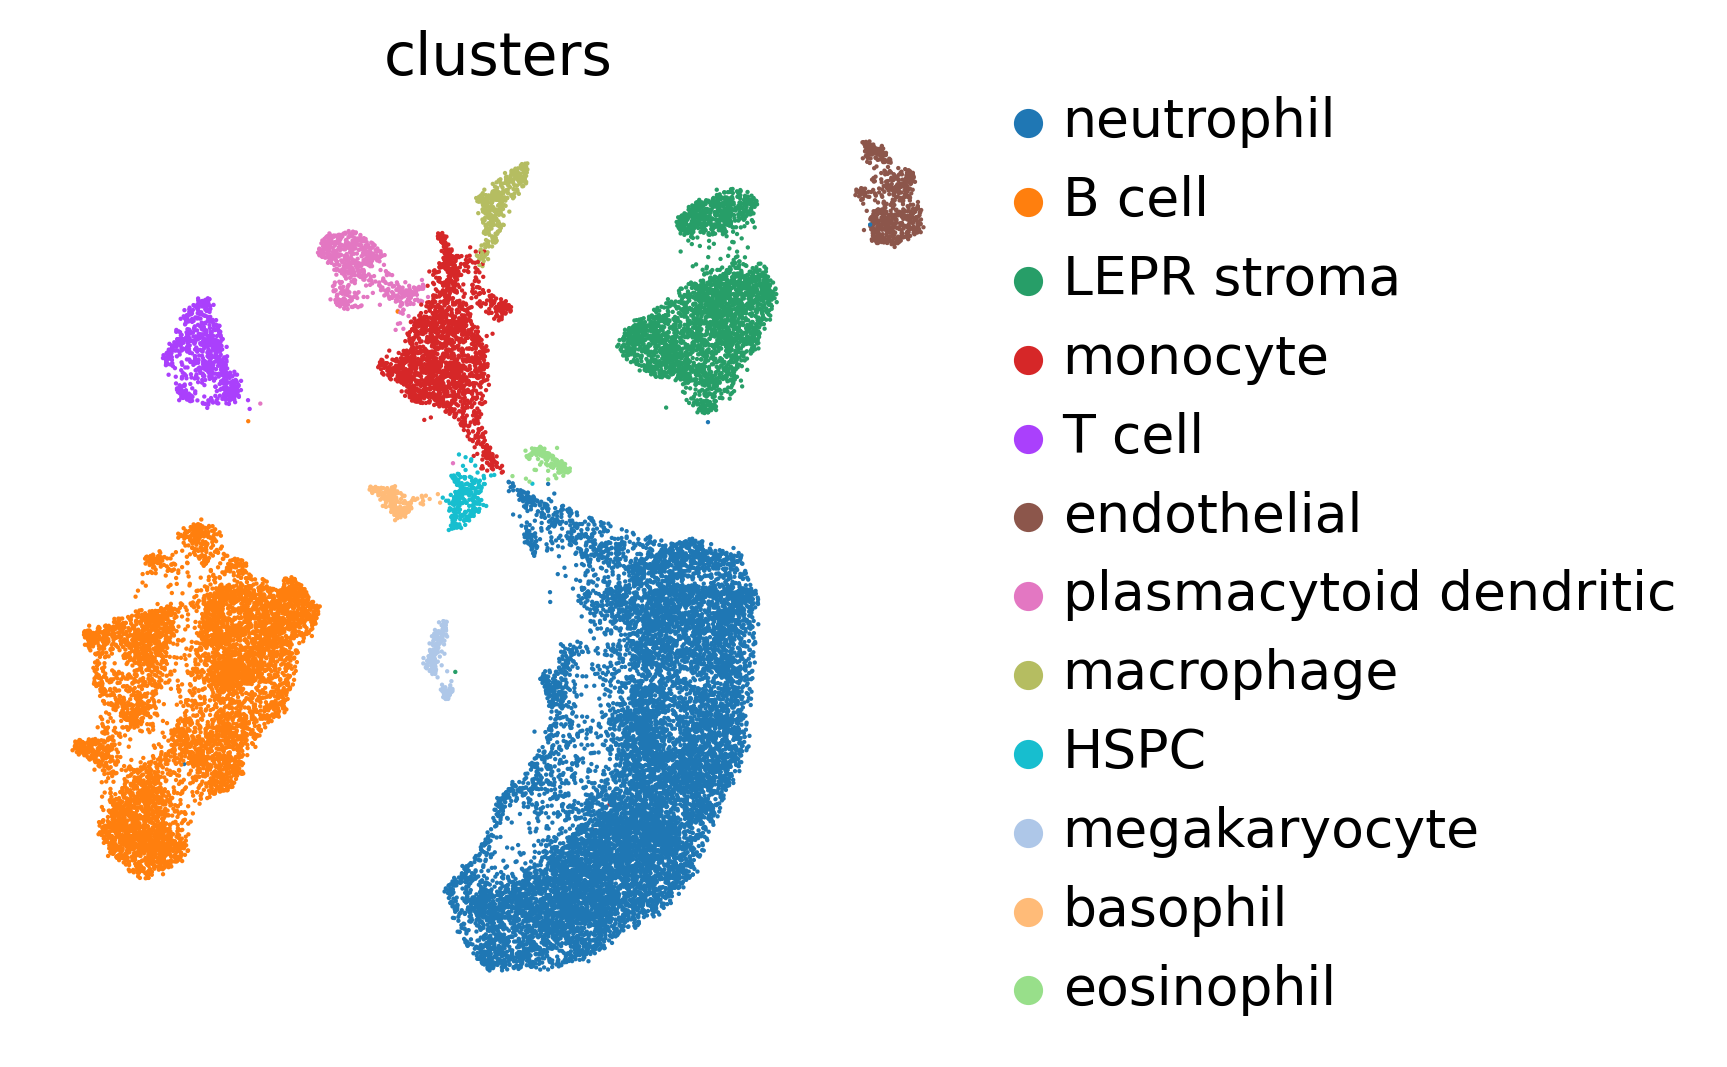

AnnData object with n_obs × n_vars = 27555 × 13806
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'percent_ribo', 'doublet_score_solo', 'singlet_score_solo', 'doublet_singlet_solo', 'clusters'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'clusters2_colors', 'clusters3_colors', 'clusters_colors', 'leiden', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'SCRAN', 'denoised', 'scVI_latent'
    obsp: 'connectivities', 'distances'

In [2]:
# import adata file
adata = anndata.read('/data/user/sfortma2/scranPY_tutorial.h5ad')
sc.pl.umap(adata, color=['clusters'], frameon=False)

# scranPY requires raw counts (i.e. not normalized and not log-transformed) in the active adata.X slot
# therefore, we set adata.X to raw denoised counts
adata.X = adata.layers['denoised'].copy()
adata


Current smallest cluster =  151  cells.
Using max_size =  3000 , clusters have been split into  18  clusters.
min_mean =  0.1
--- 3.74 mins ---
size factor min =  0.04636896023358685
size factor max =  8.977288111278305
Saved plots to: /data/user/sfortma2/scranPY_tutorial/CVXPY/scranPY_normalization.pdf


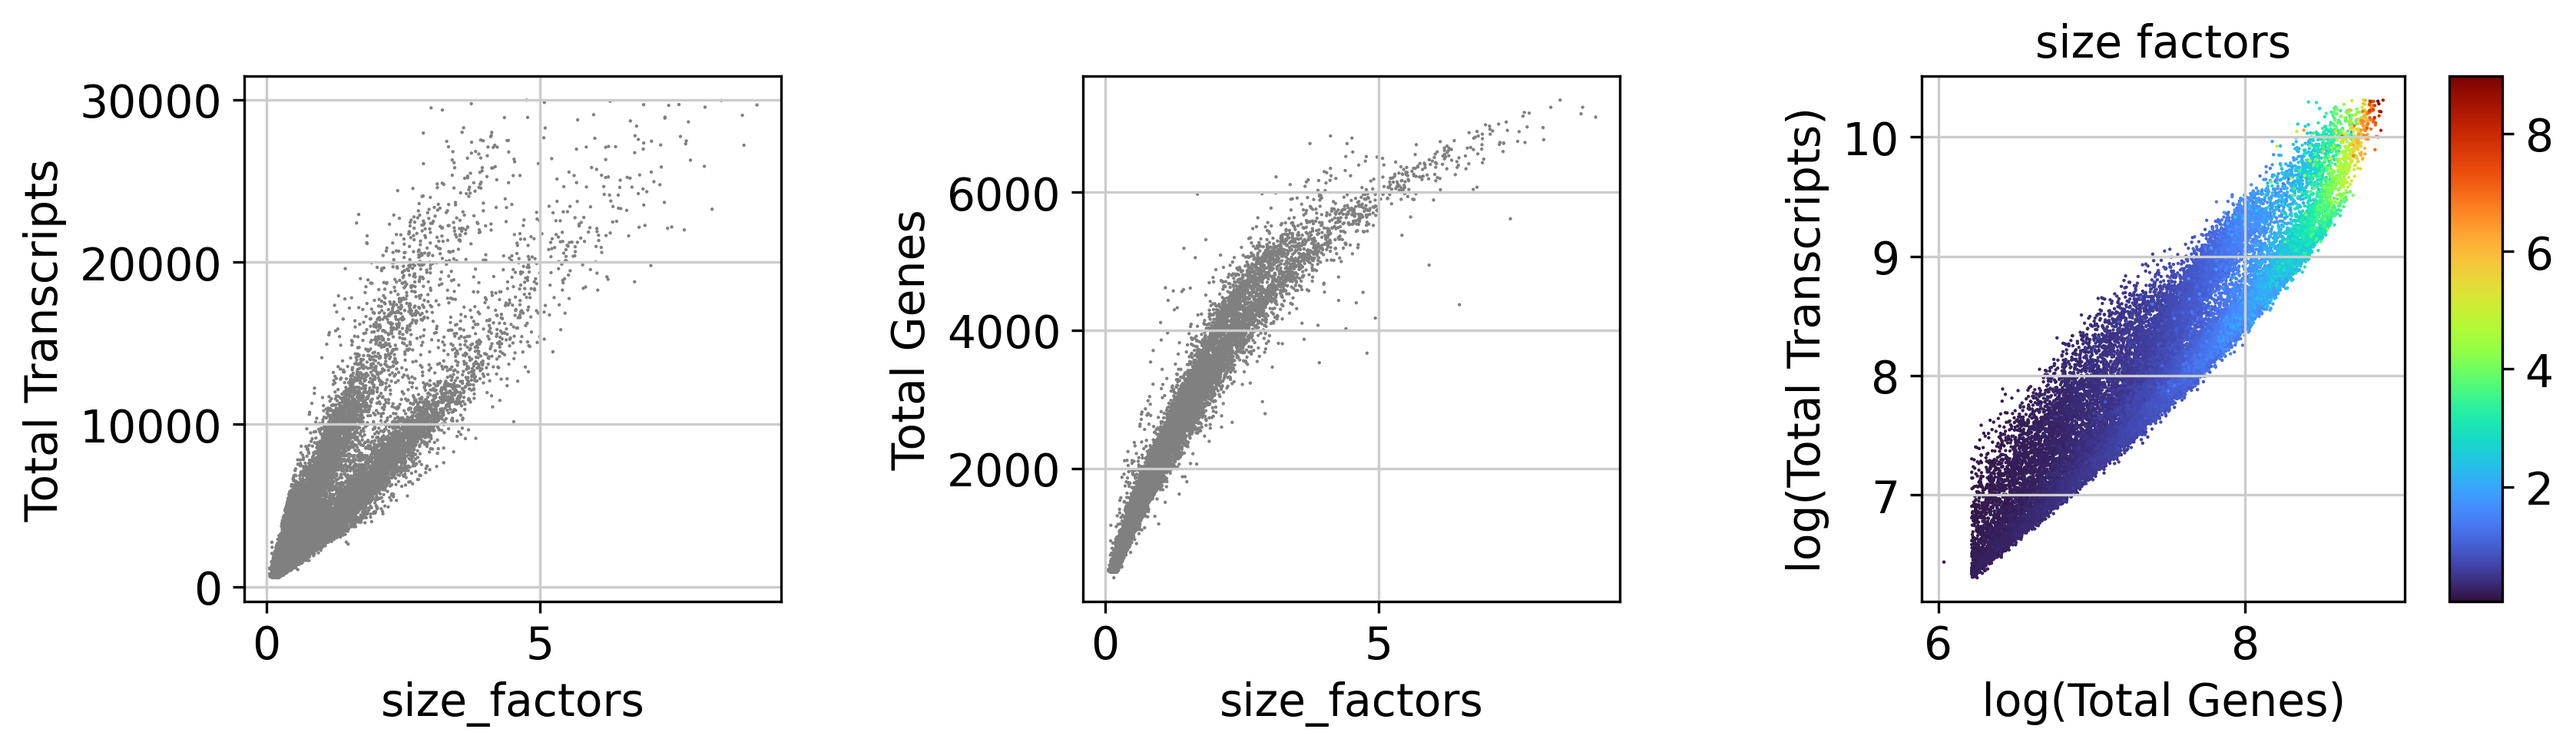

<Figure size 600x600 with 0 Axes>

In [3]:
# perform scranPY normalization using the 'CVXPY' algorithm
import scranPY
scranPY.compute_sum_factors(adata, clusters='clusters', parallelize=True, algorithm='CVXPY', max_size=3000, plotting=True,
    lower_bound=0.4, normalize_counts=False, save_plots_dir='/data/user/sfortma2/scranPY_tutorial/CVXPY')

adata.obs['CVXPY size_factors'] = adata.obs['size_factors']
del adata.obs['size_factors']


Current smallest cluster =  151  cells.
Using max_size =  3000 , clusters have been split into  18  clusters.
min_mean =  0.1
Not all size factors for clust =  17 are greater than 0. Cleaning size factors.
Not all size factors for clust =  14 are greater than 0. Cleaning size factors.


/data/user/sfortma2/.conda/envs/scanpy21_clone/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/data/user/sfortma2/.conda/envs/scanpy21_clone/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


--- 4.98 mins ---
size factor min =  0.01080515386896362
size factor max =  9.286512000217206
Saved plots to: /data/user/sfortma2/scranPY_tutorial/QR/scranPY_normalization.pdf


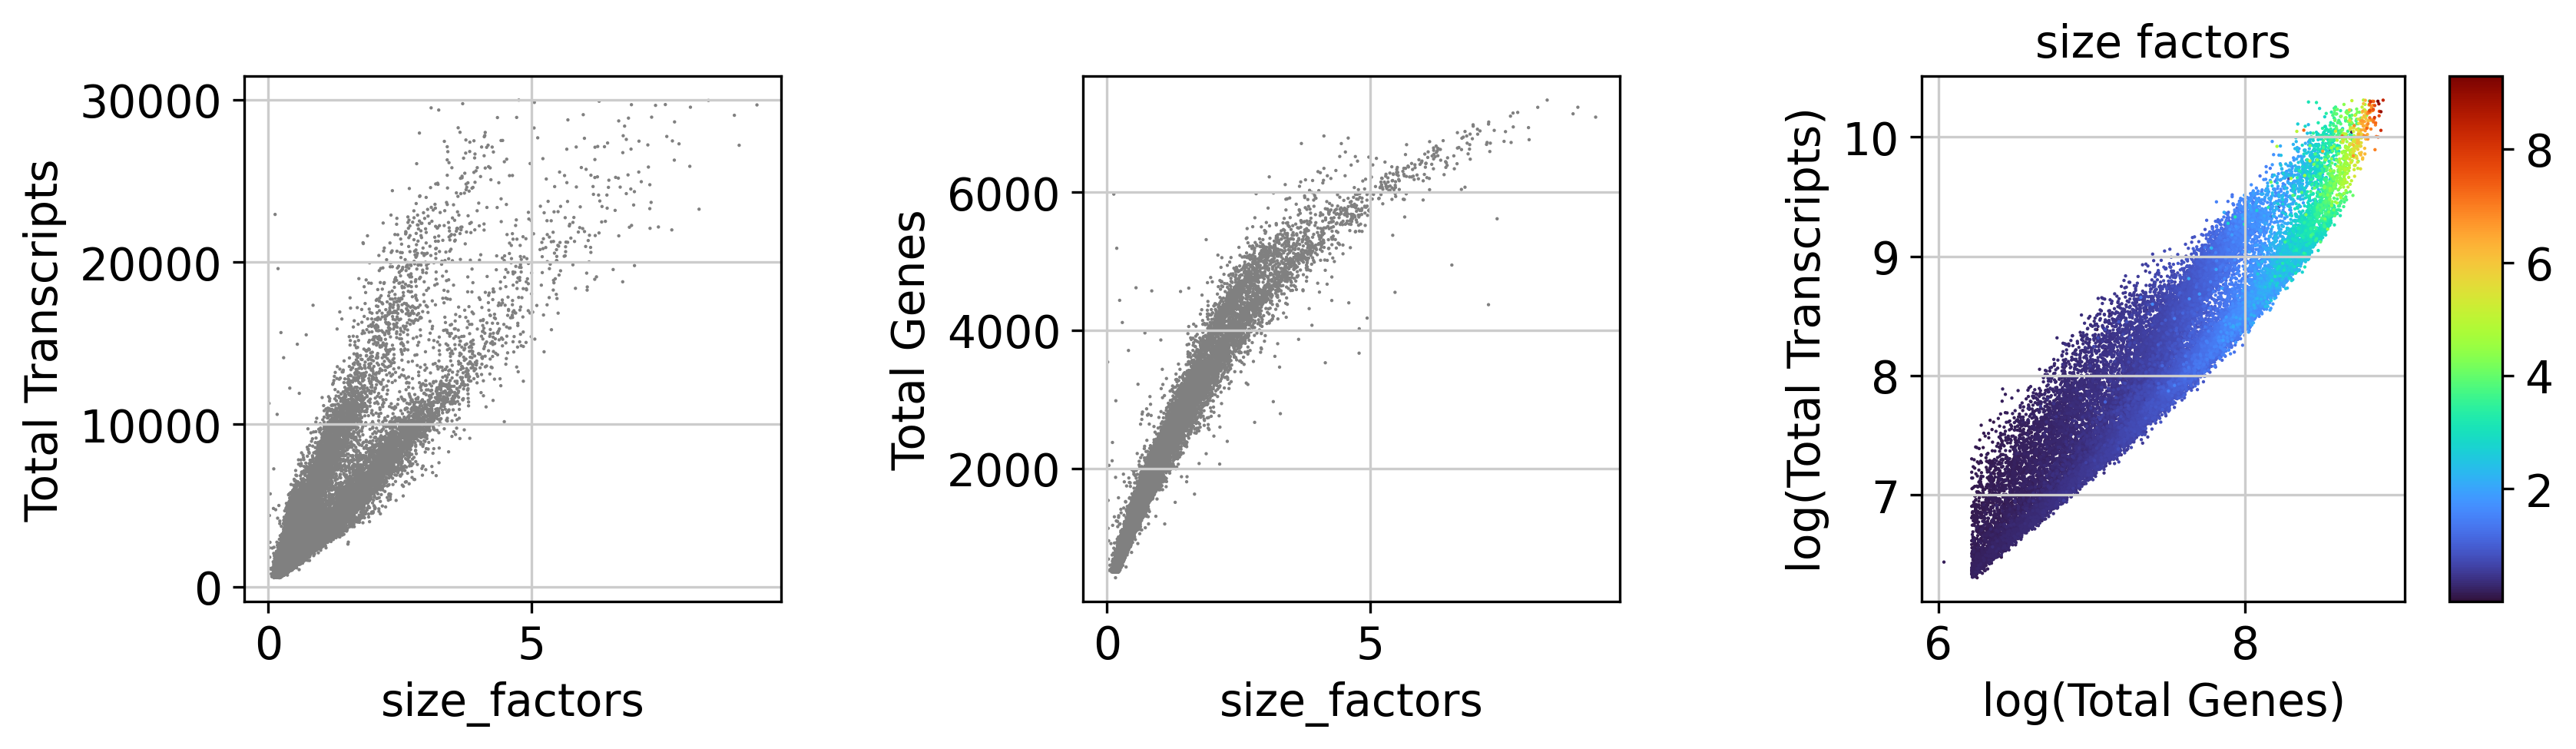

<Figure size 600x600 with 0 Axes>

In [4]:
# perform scranPY normalization using the 'QR' algorithm
scranPY.compute_sum_factors(adata, clusters='clusters', parallelize=True, algorithm='QR', max_size=3000, 
    plotting=True, normalize_counts=False, save_plots_dir='/data/user/sfortma2/scranPY_tutorial/QR')

adata.obs['QR size_factors'] = adata.obs['size_factors']
del adata.obs['size_factors']


In [5]:
# prepare data for r-scran::computeSumFactors
clusters = adata.obs['clusters']
matrix = adata.X.T


In [6]:
import time
start_time = time.time()


In [7]:
%%R -i matrix -i clusters -o size_factors

library(scran)
print(paste0('r-scran version = ',packageVersion("scran")))

start <- Sys.time()
size_factors = computeSumFactors(SingleCellExperiment::SingleCellExperiment(list(counts=matrix)), 
                                 clusters=clusters, min.mean=0.1)
print(difftime(Sys.time(), start, units='mins'))


[1] "r-scran version = 1.20.1"
Time difference of 4.290462 mins


In [8]:
# This is the full time that it takes to import the data into R, run the function, and export the size factors
print('---',round((time.time() - start_time)/60, 2),'mins ---')


--- 6.02 mins ---


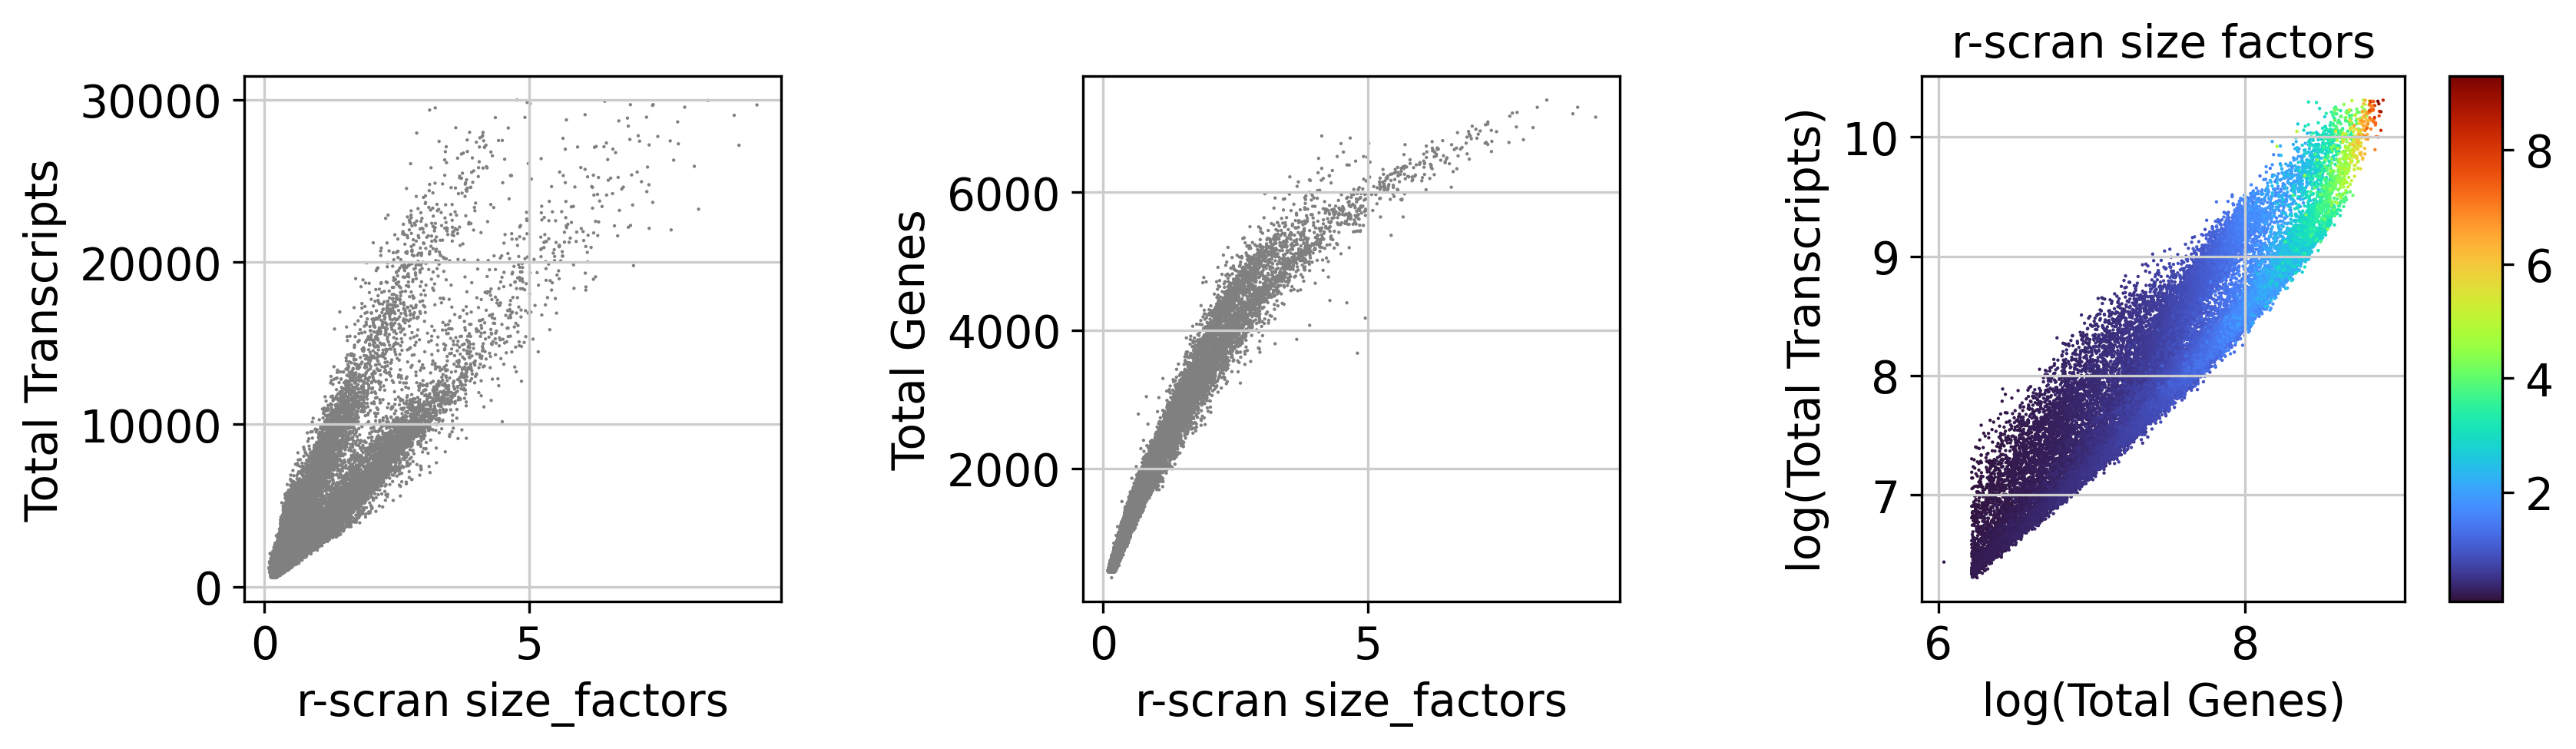

<Figure size 600x600 with 0 Axes>

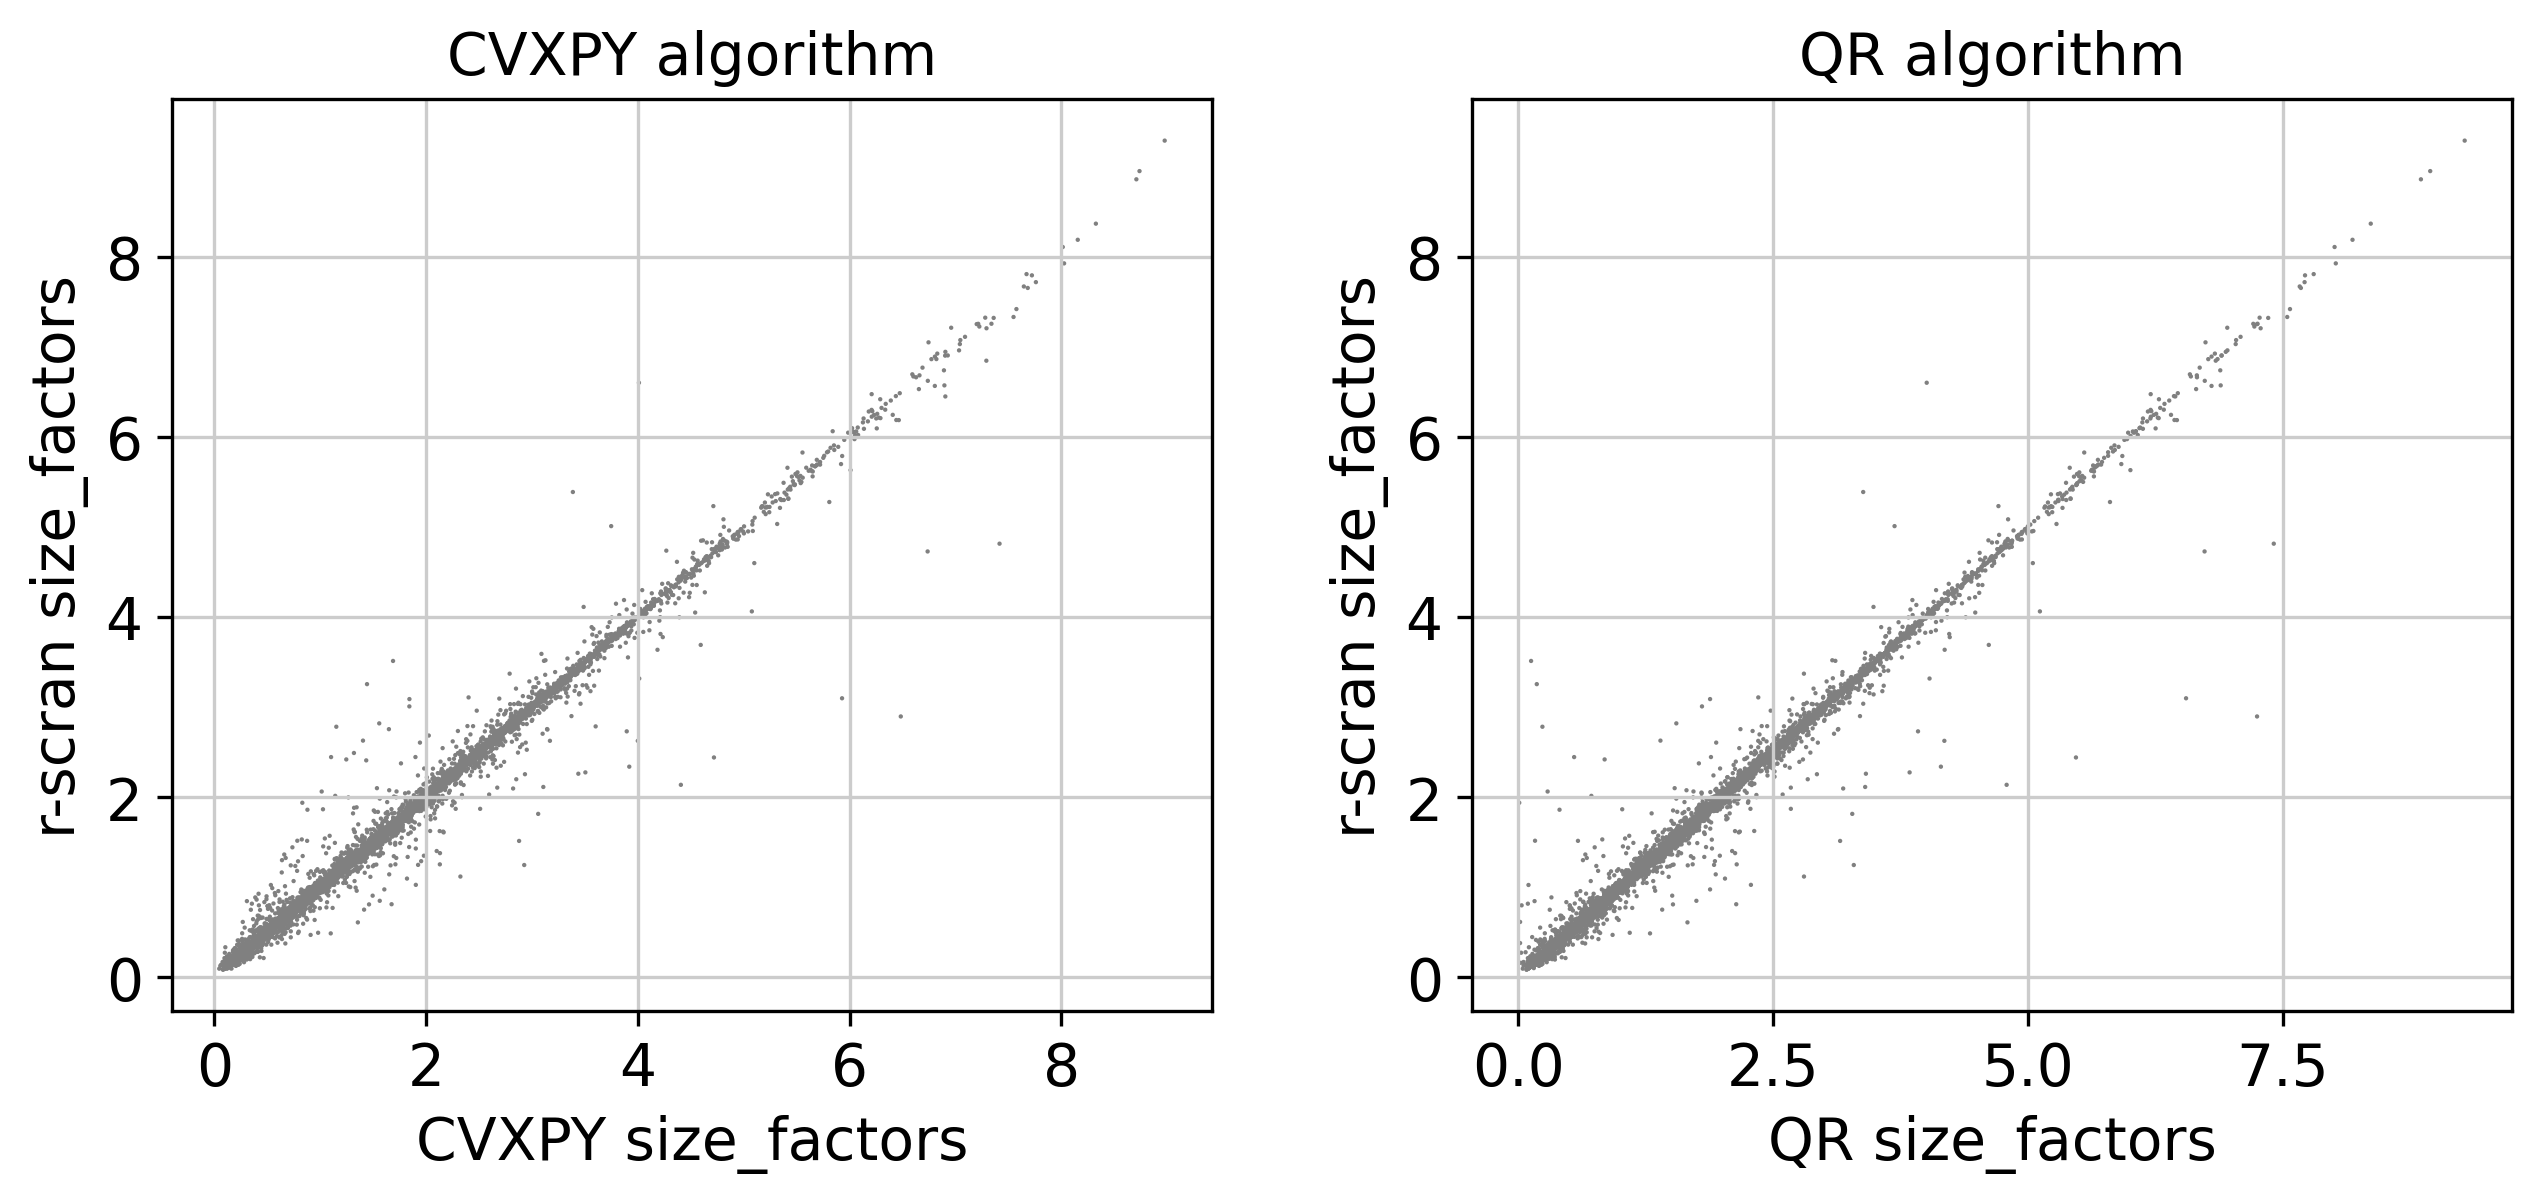

<Figure size 600x600 with 0 Axes>

In [9]:
# comparison to size factors computed using r-scran::computeSumeFactors 
adata.obs['r-scran size_factors'] = size_factors.obs['sizeFactor'].values

def make_plots(adata):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from matplotlib.cm import ScalarMappable

    fig = plt.figure(figsize=(14, 3))
    gs = gridspec.GridSpec(1, 4, width_ratios=[10, 10, 9, 1])

    adata.obs[' Total Transcripts '] = adata.X.sum(1)
    adata.obs[' Total Genes '] = (adata.X > 0).sum(1)
    adata.obs[' log(Total Transcripts) '] = np.log(adata.X.sum(1))
    adata.obs[' log(Total Genes) '] = np.log((adata.X > 0).sum(1))

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    cax = plt.subplot(gs[3])
    p1 = sc.pl.scatter(adata, x='r-scran size_factors', y=' Total Transcripts ', show=False, ax=ax1)
    p2 = sc.pl.scatter(adata, x='r-scran size_factors', y=' Total Genes ', show=False, ax=ax2)
    p3 = sc.pl.scatter(adata, x=' log(Total Genes) ', y=' log(Total Transcripts) ', 
                    color='r-scran size_factors', color_map='turbo', show=False, ax=ax3)

    del adata.obs[' Total Transcripts ']
    del adata.obs[' Total Genes ']
    del adata.obs[' log(Total Transcripts) ']
    del adata.obs[' log(Total Genes) ']

    cmap = plt.get_cmap('turbo')
    norm = plt.Normalize(vmin=p3.collections[0].get_array().min(), vmax=p3.collections[0].get_array().max())
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.subplots_adjust(wspace=0.75)
    plt.colorbar(sm, cax=cax)
    p3.collections[0].colorbar.remove()
    cax_pos = cax.get_position()
    cax.set_position([cax_pos.x0 - 0.08, cax_pos.y0, cax_pos.width, cax_pos.height])
    plt.savefig('/data/user/sfortma2/scranPY_tutorial/r-scran__comparison.pdf', bbox_inches="tight", dpi=300) 
    plt.show()
    plt.clf()
    
make_plots(adata)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
p1 = sc.pl.scatter(adata, x='CVXPY size_factors', y='r-scran size_factors', title='CVXPY algorithm', ax=axes[0], show=False)
p2 = sc.pl.scatter(adata, x='QR size_factors', y='r-scran size_factors', title='QR algorithm', ax=axes[1], show=False)
plt.subplots_adjust(wspace=0.25) 
plt.savefig('/data/user/sfortma2/scranPY_tutorial/qr_cvxpy_r-scran__comparison.pdf', bbox_inches="tight", dpi=300) 
plt.show()
plt.clf()
